In [ ]:
import math

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
type_1 = torch.zeros(128, 1, 1000)  # 10个样本，每个样本 1×100
# type_2 = torch.ones(10, 1, 12)
# labels = F.one_hot(torch.tensor([0,0,0,0,0,0,0,0,0,0]))

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)
                             * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
class VATN(nn.Module):
    def __init__(self, ):
        super(VATN, self).__init__()
        self.conv = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=50, stride=25)
        self.pos_encoder = PositionalEncoding(256)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=1024, batch_first=True),
            num_layers=8)
        self.max_pool = nn.AdaptiveMaxPool1d(4)
        self.avg_pool = nn.AdaptiveAvgPool1d(4)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(312, 64)
        self.fc_2 = nn.Linear(64, 4)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.conv(x)
        x = x.transpose(1, 2)
        x = self.pos_encoder(x)
        x = self.encoder(x)
        x_1 = self.max_pool(x)
        x_2 = self.avg_pool(x) 
        x = torch.cat((x_1, x_2), dim=2)
        x = self.flatten(x)
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = self.softmax(x)
        return x

In [ ]:
model = VATN()
out = model(type_1)
out.shape

In [ ]:
from utils.model import VATN

In [ ]:
model = VATN()
out = model(type_1)
out.shape

In [ ]:
from utils.preprocess import preprocess_data, JNUDataset

In [ ]:
BATCH_SIZE = 128
DATA_PATH = 'data'

In [51]:
train_loader = DataLoader(JNUDataset(DATA_PATH, is_train=True, device=device), batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model = VATN()
model.to(device)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
def train(model, num_epochs=1):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    loss_history = []
    acc_history = []
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            # data = data.to(device)
            # target = target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.to(torch.float32))
            loss.backward()
            optimizer.step()
            accuracy = (output.argmax(dim=1) == target.argmax(dim=1)).float().mean().to('cpu').numpy()
            # print(accuracy)
            # if batch_idx % 8 == 0:
            #     # print(output)
            #     # print(target.shape)
            #     print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
            #             f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        if epoch == num_epochs-1:
            print(output)
            print(target)
                
        loss_history.append(loss.item())
        acc_history.append(accuracy)
    print('Finished Training')
    plt.plot(loss_history)
    plt.plot(acc_history)
    # return loss_history

In [46]:
a = torch.tensor([[1,2,3],[4,5,6]])
b = a.numpy()

tensor([[2.8952e-08, 2.8766e-10, 5.7917e-14, 1.0000e+00],
        [4.4807e-23, 3.2638e-14, 1.0000e+00, 4.5213e-14],
        [2.4101e-09, 1.0000e+00, 1.4992e-13, 2.0829e-13],
        [1.0000e+00, 1.5487e-06, 4.2845e-24, 3.7172e-08],
        [1.0395e-07, 3.3138e-10, 1.3801e-14, 1.0000e+00],
        [1.3277e-09, 1.0000e+00, 6.8625e-10, 4.7794e-11],
        [1.0437e-27, 7.1053e-17, 1.0000e+00, 5.3165e-18],
        [1.0000e+00, 1.7779e-06, 1.0646e-23, 5.6665e-08],
        [9.4636e-12, 1.0000e+00, 3.6960e-13, 1.0364e-15],
        [1.3305e-08, 1.7286e-12, 3.0460e-16, 1.0000e+00],
        [1.0000e+00, 1.8157e-06, 4.6253e-24, 2.8665e-08],
        [1.3328e-24, 4.1400e-15, 1.0000e+00, 3.8496e-15],
        [3.1299e-07, 1.9557e-09, 6.5513e-14, 1.0000e+00],
        [8.0011e-28, 2.7875e-17, 1.0000e+00, 6.0830e-18],
        [1.2577e-05, 9.9999e-01, 1.5391e-14, 5.9544e-11],
        [5.4773e-09, 3.0413e-12, 2.2364e-15, 1.0000e+00],
        [1.1232e-26, 1.7153e-16, 1.0000e+00, 6.7396e-17],
        [1.000

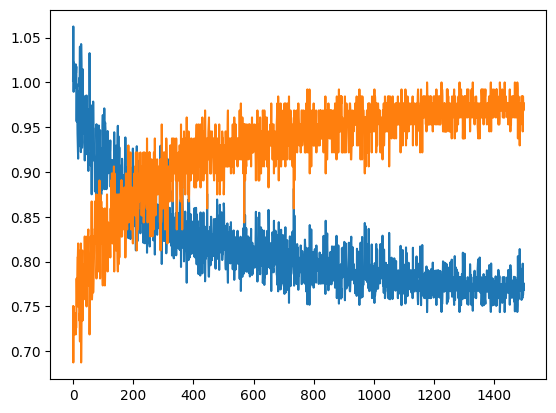

In [56]:
train(model, 1500)

In [57]:
torch.save(model.state_dict(), 'vatn_1500.pth')

In [58]:
test_loader = DataLoader(JNUDataset(DATA_PATH, is_train=False, device=device), batch_size=BATCH_SIZE, shuffle=False)

In [91]:
def test(model, test_loader):
    correct = 0
    all_pred_labels = torch.tensor([])
    all_true_labels = torch.tensor([])
    with torch.no_grad():
        for data, target in test_loader:
            # data = data.to(device)
            # target = target.to(device)
            output = model(data)
            pred_labels = output.argmax(dim=1, keepdim=True)
            true_labels = target.argmax(dim=1, keepdim=True)
            all_pred_labels = torch.cat((all_pred_labels, pred_labels.to('cpu')), dim=0)
            all_true_labels = torch.cat((all_true_labels, true_labels.to('cpu')), dim=0)
            correct += pred_labels.eq(true_labels).sum().item()
            # print(pred)
            # print(target.argmax(dim=1, keepdim=True))
            # print('---')
            # accuracy = (output.argmax(dim=1) == target.argmax(dim=1)).float().mean().to('cpu').numpy()
            # pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # correct += pred.eq(target.to(torch.float32).view_as(pred)).sum().item()
            
    # test_loss /= len(test_loader.dataset)
    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)
    # ))
    # return test_loss, 100. * correct / len(test_loader.dataset)
    return correct / len(test_loader.dataset), all_pred_labels.numpy(), all_true_labels.numpy()



In [71]:
a = torch.tensor([[1],[1], [1]])
b = torch.tensor([[1],[1], [0]])
b.eq(a).sum().item()

2

In [ ]:
accuracy, preds, trues = test(model, test_loader)
preds.tolist()

In [108]:
accuracy

0.9220833333333334

In [80]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [87]:
classes = [0, 1, 2, 3]

In [106]:
def draw_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    cmap=plt.cm.Blues
    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    
    plt.title('Confusion Matrix', fontsize=15)
    plt.xlabel('Predicted Category', fontsize=12)
    plt.ylabel('Target Category', fontsize=12)
    plt.tick_params(labelsize=12) 
    plt.xticks(tick_marks, classes, rotation=90) 
    plt.yticks(tick_marks, classes)
    
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('confusion_matrix.png')
    plt.show()

[[576  19   0   5]
 [ 26 549   6  19]
 [  3  11 573  13]
 [  6  67  12 515]]


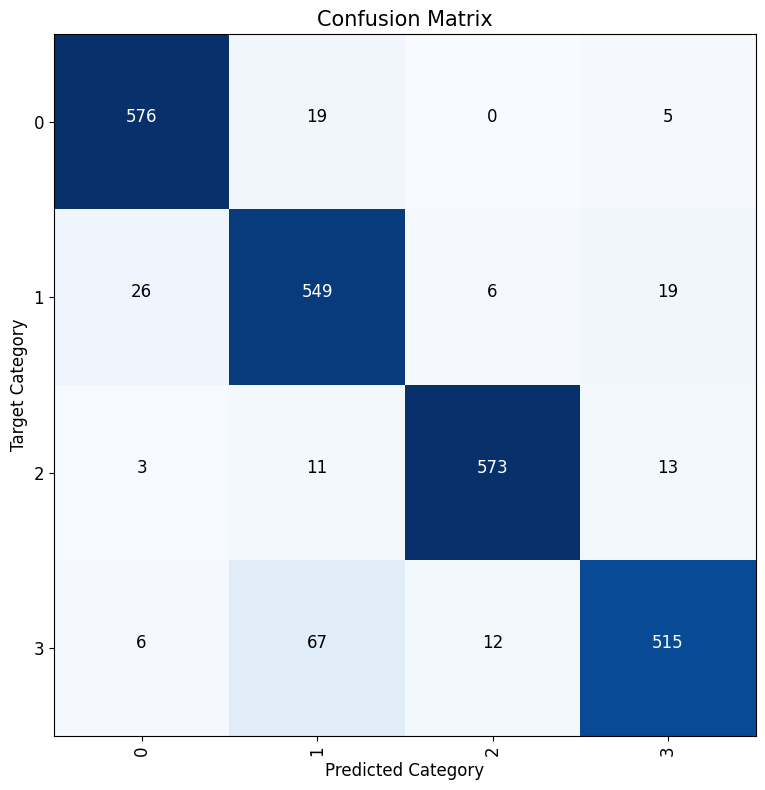

In [107]:
draw_confusion_matrix(trues.tolist(), preds.tolist())

In [ ]:
def train(model, num_epochs=1):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    loss_history = []
    acc_history = []
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            # data = data.to(device)
            # target = target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.to(torch.float32))
            loss.backward()
            optimizer.step()
            accuracy = (output.argmax(dim=1) == target.argmax(dim=1)).float().mean().to('cpu').numpy()
            # print(accuracy)
            # if batch_idx % 8 == 0:
            #     # print(output)
            #     # print(target.shape)
            #     print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
            #             f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        if epoch == num_epochs-1:
            print(output)
            print(target)
                
        loss_history.append(loss.item())
        acc_history.append(accuracy)
    print('Finished Training')
    plt.plot(loss_history)
    plt.plot(acc_history)